In [25]:
# FFT Library-Based Specular Highlight Removal

import cv2
import numpy as np
import torch
from scipy import fft
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time
import os

# Set device for PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def compute_fft_signature(frame, mask=None, scale_factor=0.25):
    """
    Compute FFT signature for a frame, optionally excluding highlighted areas
    
    Parameters:
    frame: Input frame (BGR format)
    mask: Optional mask to exclude regions (1 for regions to keep, 0 for regions to exclude)
    scale_factor: Factor to reduce resolution for faster processing
    
    Returns:
    signature: FFT magnitude spectrum as a flattened array (normalized)
    """
    # Resize for faster processing
    h, w = frame.shape[:2]
    resized = cv2.resize(frame, (int(w * scale_factor), int(h * scale_factor)), interpolation=cv2.INTER_AREA)
    
    # Convert to grayscale
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    
    # Apply mask if provided
    if mask is not None:
        # Resize mask to match the resized frame
        mask_resized = cv2.resize(mask, (gray.shape[1], gray.shape[0]), interpolation=cv2.INTER_NEAREST)
        gray = gray * (mask_resized > 0)
    
    # Apply FFT
    f_transform = fft.fft2(gray)
    f_shift = fft.fftshift(f_transform)
    
    # Get magnitude spectrum
    magnitude = np.abs(f_shift)
    
    # Take log to enhance visibility of patterns
    magnitude = np.log1p(magnitude)
    
    # Normalize to 0-1 range
    min_val = np.min(magnitude)
    max_val = np.max(magnitude)
    if max_val > min_val:
        magnitude = (magnitude - min_val) / (max_val - min_val)
    
    # Optional: Apply frequency mask to focus on mid-frequencies
    h, w = magnitude.shape
    y, x = np.ogrid[:h, :w]
    center_y, center_x = h // 2, w // 2
    
    # Create frequency mask (band-pass filter)
    inner_radius = min(h, w) * 0.05  # Exclude low frequencies
    outer_radius = min(h, w) * 0.5   # Exclude high frequencies
    
    dist_from_center = np.sqrt((y - center_y)**2 + (x - center_x)**2)
    freq_mask = (dist_from_center > inner_radius) & (dist_from_center < outer_radius)
    
    # Apply frequency mask
    magnitude = magnitude * freq_mask
    
    # Flatten to create signature
    signature = magnitude.flatten()
    
    return signature

def calculate_signature_difference(signature1, signature2):
    """
    Calculate difference between two FFT signatures
    
    Parameters:
    signature1, signature2: FFT signatures to compare
    
    Returns:
    difference: Normalized difference score
    """
    # Can use various metrics: cosine distance, euclidean, etc.
    # Using simple euclidean distance for now
    diff = np.sqrt(np.sum((signature1 - signature2)**2))
    
    # Normalize by vector length
    diff = diff / len(signature1)
    
    return diff

def create_fft_library(video_path, interval=125, scale_factor=0.25, max_frames=None):
    """
    Create a library of FFT signatures from video frames
    
    Parameters:
    video_path: Path to the video file
    interval: Sample every N frames
    scale_factor: Factor to reduce frame resolution for FFT
    max_frames: Maximum number of frames to process
    
    Returns:
    library: Dictionary of frame indices and their FFT signatures
    """
    library = {}
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if max_frames is not None:
        total_frames = min(total_frames, max_frames)
    
    print(f"Creating FFT library from {video_path}")
    print(f"Processing {total_frames} frames at interval {interval}")
    
    frame_count = 0
    
    for frame_idx in tqdm(range(0, total_frames, interval), desc="Building FFT library"):
        # Set position to the desired frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        
        # Read the frame
        ret, frame = cap.read()
        if not ret:
            break
        
        # Compute FFT signature
        try:
            start_time = time.time()
            signature = compute_fft_signature(frame, scale_factor=scale_factor)
            processing_time = time.time() - start_time
            
            # Store in library
            library[frame_idx] = {
                'signature': signature,
                'frame_idx': frame_idx
            }
            
            frame_count += 1
            
            if frame_count == 1:
                print(f"FFT signature calculation time: {processing_time:.4f} seconds per frame")
                
        except Exception as e:
            print(f"Error processing frame {frame_idx}: {e}")
    
    cap.release()
    print(f"FFT library created with {len(library)} entries")
    
    return library

def detect_specular_highlights(frame, brightness_threshold=0.86, size_threshold=10):
    """
    Detect specular highlights in a frame
    
    Parameters:
    frame: Input frame (BGR format)
    brightness_threshold: Threshold for highlight detection (0-1 range)
    size_threshold: Minimum size of regions to consider
    
    Returns:
    mask: Binary mask of highlighted regions
    """
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Apply threshold
    _, binary = cv2.threshold(gray, int(brightness_threshold * 255), 255, cv2.THRESH_BINARY)
    
    # Clean up with morphological operations
    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    # Remove small regions
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)
    
    mask = np.zeros_like(binary)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= size_threshold:
            mask[labels == i] = 255
    
    return mask

def find_best_replacement_frame(current_signature, library, current_idx, max_distance=1000):
    """
    Find the best replacement frame from the library
    
    Parameters:
    current_signature: FFT signature of current frame
    library: Dictionary of frame indices and their FFT signatures
    current_idx: Index of current frame
    max_distance: Maximum temporal distance to consider
    
    Returns:
    best_idx: Index of best replacement frame
    """
    best_difference = 0
    best_idx = None
    
    for lib_idx, entry in library.items():
        # Skip current frame or frames too close to it
        if abs(lib_idx - current_idx) < 10:
            continue
        
        # Skip frames too far away
        if abs(lib_idx - current_idx) > max_distance:
            continue
        
        # Calculate difference
        difference = calculate_signature_difference(current_signature, entry['signature'])
        
        # Find the most different frame within range
        if difference > best_difference:
            best_difference = difference
            best_idx = lib_idx
    
    # If no suitable frame found, pick one at random within range
    if best_idx is None:
        valid_frames = [idx for idx in library.keys() 
                     if abs(idx - current_idx) >= 10 and abs(idx - current_idx) <= max_distance]
        if valid_frames:
            best_idx = np.random.choice(valid_frames)
    
    return best_idx

def process_video_with_fft_library(video_path, output_path, library, 
                                  brightness_threshold=0.86, start_frame=0, 
                                  num_frames=None, scale_factor=0.25):
    """
    Process video using FFT library for replacement frames
    
    Parameters:
    video_path: Path to input video
    output_path: Path for output video
    library: FFT signature library
    brightness_threshold: Threshold for highlight detection
    start_frame: Starting frame index
    num_frames: Number of frames to process
    scale_factor: Factor to reduce resolution for FFT
    """
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if num_frames is None:
        num_frames = total_frames - start_frame
    else:
        num_frames = min(num_frames, total_frames - start_frame)
    
    # Create output video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Set starting position
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    # Process frames
    print(f"Processing {num_frames} frames starting from frame {start_frame}")
    frames_processed = 0
    frames_with_highlights = 0
    
    # Cache for replacement frames
    replacement_cache = {}
    
    for _ in tqdm(range(num_frames), desc="Processing video"):
        # Read current frame
        ret, current_frame = cap.read()
        if not ret:
            break
        
        current_idx = start_frame + frames_processed
        
        # Detect highlights
        highlight_mask = detect_specular_highlights(current_frame, brightness_threshold)
        
        # If no highlights, write original frame and continue
        if cv2.countNonZero(highlight_mask) == 0:
            out.write(current_frame)
            frames_processed += 1
            continue
        
        frames_with_highlights += 1
        
        # Create inverse mask for non-highlight areas
        non_highlight_mask = 255 - highlight_mask
        
        # Compute FFT signature for current frame, excluding highlights
        current_signature = compute_fft_signature(current_frame, non_highlight_mask, scale_factor)
        
        # Find best replacement frame
        best_idx = find_best_replacement_frame(current_signature, library, current_idx)
        
        if best_idx is not None:
            # Load replacement frame (either from cache or from video)
            if best_idx in replacement_cache:
                replacement_frame = replacement_cache[best_idx]
            else:
                # Save current position
                current_pos = cap.get(cv2.CAP_PROP_POS_FRAMES)
                
                # Get replacement frame
                cap.set(cv2.CAP_PROP_POS_FRAMES, best_idx)
                ret, replacement_frame = cap.read()
                
                # Restore position
                cap.set(cv2.CAP_PROP_POS_FRAMES, current_pos)
                
                # Cache the replacement frame
                replacement_cache[best_idx] = replacement_frame.copy()
            
            # Convert masks to 3-channel for blending
            highlight_mask_3ch = cv2.merge([highlight_mask] * 3) / 255.0
            
            # Create result by blending current frame and replacement frame
            result = current_frame.copy()
            
            # Only copy the highlighted regions from the replacement frame
            result = (1 - highlight_mask_3ch) * result + highlight_mask_3ch * replacement_frame
            result = result.astype(np.uint8)
            
            # Write result frame
            out.write(result)
        else:
            # If no suitable replacement found, use original frame
            out.write(current_frame)
        
        frames_processed += 1
        
        # Clear cache periodically to avoid memory issues
        if frames_processed % 100 == 0 and replacement_cache:
            # Only keep recent frames in cache
            keys_to_keep = sorted(replacement_cache.keys(), reverse=True)[:10]
            replacement_cache = {k: replacement_cache[k] for k in keys_to_keep}
    
    # Release resources
    cap.release()
    out.release()
    
    print(f"Video processing complete")
    print(f"Processed {frames_processed} frames, found highlights in {frames_with_highlights} frames")
    print(f"Output saved to {output_path}")
    
    return output_path

def test_fft_library(video_path, library, test_frame_idx=1000, brightness_threshold=0.86, scale_factor=0.25):
    """
    Test the FFT library by visualizing replacement for a test frame
    
    Parameters:
    video_path: Path to video file
    library: FFT signature library
    test_frame_idx: Index of test frame
    brightness_threshold: Threshold for highlight detection
    scale_factor: Scale factor for FFT calculation
    """
    cap = cv2.VideoCapture(video_path)
    
    # Get test frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, test_frame_idx)
    ret, test_frame = cap.read()
    if not ret:
        print(f"Could not read frame {test_frame_idx}")
        cap.release()
        return
    
    # Detect highlights
    highlight_mask = detect_specular_highlights(test_frame, brightness_threshold)
    
    # If no highlights, pick another frame
    if cv2.countNonZero(highlight_mask) == 0:
        print(f"No highlights detected in frame {test_frame_idx}")
        cap.release()
        return
    
    # Create inverse mask for non-highlight areas
    non_highlight_mask = 255 - highlight_mask
    
    # Compute FFT signature for test frame, excluding highlights
    test_signature = compute_fft_signature(test_frame, non_highlight_mask, scale_factor)
    
    # Find best replacement frame
    best_idx = find_best_replacement_frame(test_signature, library, test_frame_idx)
    
    if best_idx is not None:
        print(f"Best replacement frame: {best_idx} (distance from test: {abs(best_idx - test_frame_idx)} frames)")
        
        # Get replacement frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, best_idx)
        ret, replacement_frame = cap.read()
        
        if ret:
            # Create output by replacing highlights
            highlight_mask_3ch = cv2.merge([highlight_mask] * 3) / 255.0
            result = test_frame.copy()
            result = (1 - highlight_mask_3ch) * result + highlight_mask_3ch * replacement_frame
            result = result.astype(np.uint8)
            
            # Create highlighted version of test frame
            highlighted = test_frame.copy()
            highlighted[highlight_mask > 0] = [0, 0, 255]  # Red for highlights
            
            # Display results
            fig, axes = plt.subplots(2, 2, figsize=(20, 12))
            
            axes[0, 0].imshow(cv2.cvtColor(test_frame, cv2.COLOR_BGR2RGB))
            axes[0, 0].set_title(f'Original Frame (#{test_frame_idx})')
            axes[0, 0].axis('off')
            
            axes[0, 1].imshow(cv2.cvtColor(highlighted, cv2.COLOR_BGR2RGB))
            axes[0, 1].set_title('Detected Highlights')
            axes[0, 1].axis('off')
            
            axes[1, 0].imshow(cv2.cvtColor(replacement_frame, cv2.COLOR_BGR2RGB))
            axes[1, 0].set_title(f'Replacement Frame (#{best_idx})')
            axes[1, 0].axis('off')
            
            axes[1, 1].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
            axes[1, 1].set_title('Result with Replaced Highlights')
            axes[1, 1].axis('off')
            
            plt.tight_layout()
            plt.show()
        else:
            print(f"Could not read replacement frame {best_idx}")
    else:
        print("No suitable replacement frame found")
    
    cap.release()

Using device: cuda


Getting FFT signature library...
FFT library loaded from video1_fft_library.pkl
Load time: 0.64 seconds
Contains 203 frame signatures

Visualizing FFT differences for sample frame...


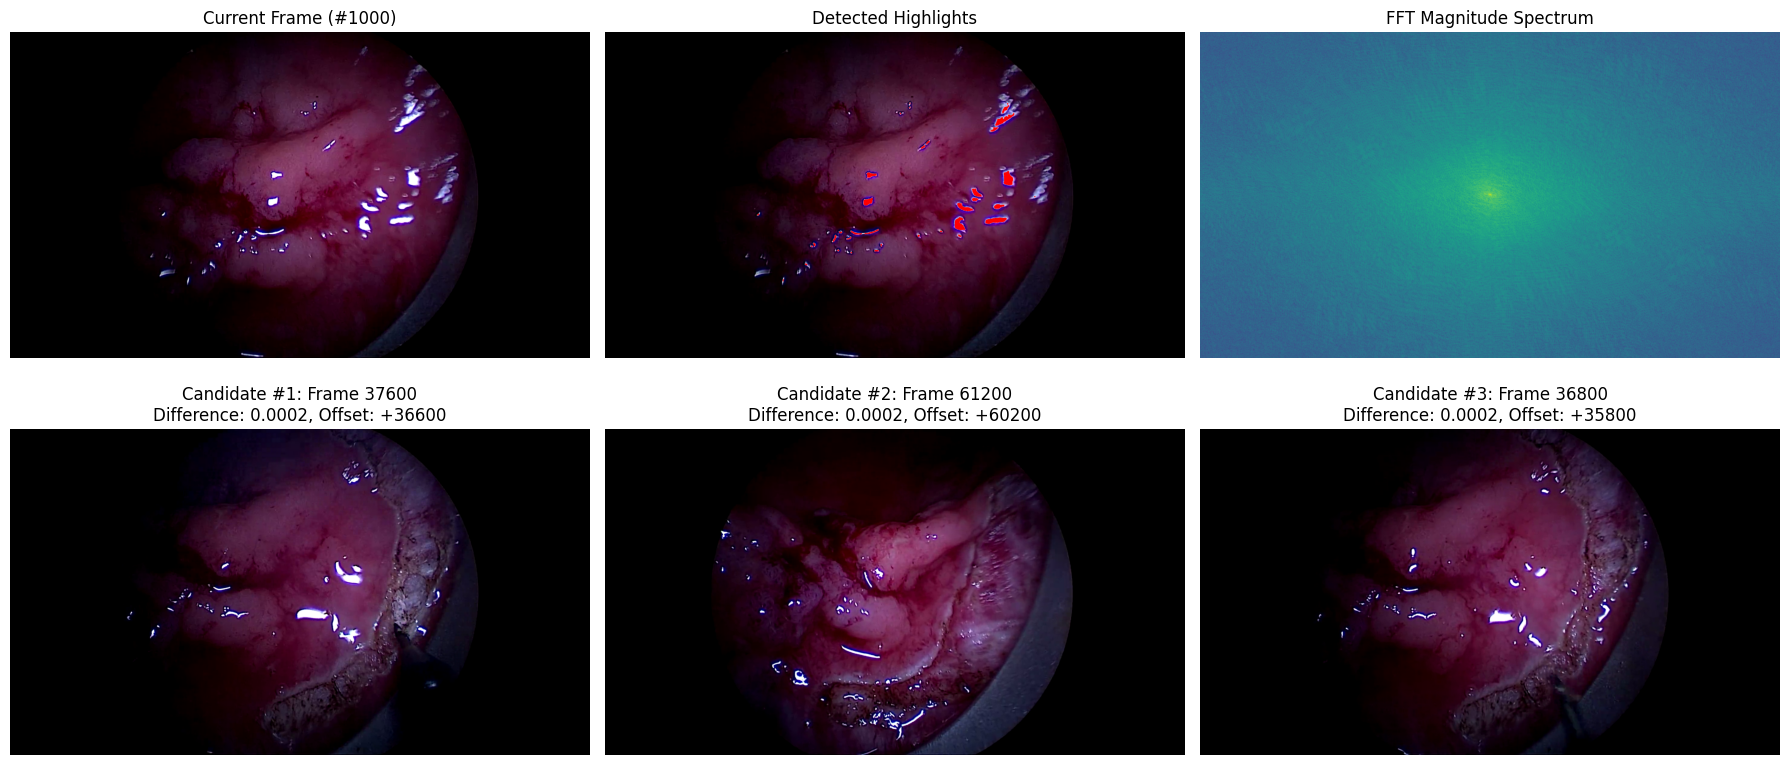


Processing video section with adaptive selection (250 frames)...
Processing 250 frames starting from frame 1000


Processing video:   0%|          | 0/250 [00:00<?, ?it/s]

Using fallback replacement: Frame 2000, difference = 0.0014 (below threshold)
Using fallback replacement: Frame 2000, difference = 0.0014 (below threshold)
Using fallback replacement: Frame 2000, difference = 0.0014 (below threshold)
Using fallback replacement: Frame 2000, difference = 0.0014 (below threshold)
Using fallback replacement: Frame 2000, difference = 0.0014 (below threshold)
Using fallback replacement: Frame 2000, difference = 0.0014 (below threshold)
Using fallback replacement: Frame 2000, difference = 0.0014 (below threshold)
Using fallback replacement: Frame 2000, difference = 0.0014 (below threshold)
Using fallback replacement: Frame 2000, difference = 0.0014 (below threshold)
Using fallback replacement: Frame 2000, difference = 0.0014 (below threshold)
Using fallback replacement: Frame 2000, difference = 0.0014 (below threshold)
Using fallback replacement: Frame 2000, difference = 0.0014 (below threshold)
Using fallback replacement: Frame 2000, difference = 0.0014 (bel

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_102/1948457619.py", line 35, in <module>
    process_video_with_adaptive_selection(
  File "/tmp/ipykernel_102/1133270050.py", line 1012, in process_video_with_adaptive_selection
    highlight_mask = detect_specular_highlights(current_frame, brightness_threshold)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_102/1133270050.py", line None, in detect_specular_highlights
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/

In [24]:
# Run this code to process your video using the FFT library method

video_path = 'video1.mp4'
library_interval = 300  # Sample every 125 frames (1 second at 125fps)
scale_factor = 0.25     # Process at 25% resolution for speed

# 1. Create FFT signature library
# This can take some time but only needs to be done once for the video
print("Creating FFT signature library...")
fft_library = create_fft_library(
    video_path=video_path,
    interval=library_interval,
    scale_factor=scale_factor,
    max_frames=None  # Process the entire video
)

# 2. Test the library on a sample frame
print("\nTesting FFT library on a sample frame...")
test_fft_library(
    video_path=video_path,
    library=fft_library,
    test_frame_idx=1000,  # Test on frame 1000
    brightness_threshold=0.86,
    scale_factor=scale_factor
)

# 3. Process a section of the video
section_frames = 250  # Process 250 frames (2 seconds at 125 fps)
section_start_frame = 1000  # Start at frame 1000
output_path = 'video1_fft_library_processed.mp4'

print(f"\nProcessing video section ({section_frames} frames)...")
process_video_with_fft_library(
    video_path=video_path,
    output_path=output_path,
    library=fft_library,
    brightness_threshold=0.86,
    start_frame=section_start_frame,
    num_frames=section_frames,
    scale_factor=scale_factor
)

print("\nFFT library-based processing complete!")
print(f"Output video saved to: {output_path}")

# 4. Process the full video (uncomment when ready)
"""
full_output_path = 'video1_full_fft_processed.mp4'

print("\nProcessing the entire video...")
process_video_with_fft_library(
    video_path=video_path,
    output_path=full_output_path,
    library=fft_library,
    brightness_threshold=0.86,
    start_frame=0,
    num_frames=None,  # Process all frames
    scale_factor=scale_factor
)

print(f"Full video processing complete! Output saved to: {full_output_path}")
"""